<a href="https://colab.research.google.com/github/justincharney/Python_Machine_Learning/blob/main/Crack_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
#!pip install -q pathlib
from pathlib import Path


In [ ]:
!pip install -q fastbook
from fastbook import*

In [ ]:
!pip install -q semtorch

In [ ]:
from semtorch import get_segmentation_learner

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/Images and Labels')

In [ ]:
fnames = get_image_files(path/'Images')

In [ ]:
lbls = get_image_files(path/"Maks")

In [ ]:
#mask = load_image(lbls[0])
#mask

In [ ]:
def label_func(x):
  return path/'Masks'/f'{x.stem}.jpg'

# FastAI


In [ ]:
#cracks = DataBlock(blocks = (ImageBlock, ImageBlock),
                   #get_items = get_image_files,
                   #splitter=RandomSplitter(),
                   #get_y= label_func,
                   #item_tfms=Resize(224),
                   #batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
#dls = cracks.dataloaders(path/"Images", bs=1)

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path/"Images", fnames, label_func=label_func, bs=5, item_tfms=RandomResizedCrop(224), batch_tfms=[Normalize.from_stats(*imagenet_stats)])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


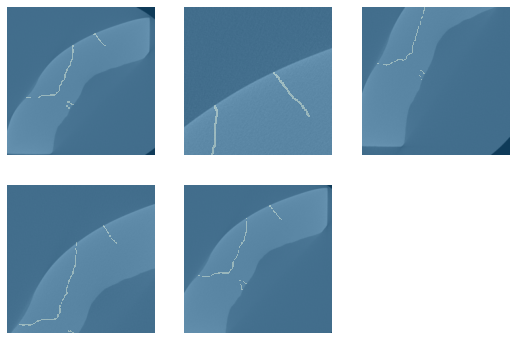

In [ ]:
dls.train.show_batch()

In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis) 
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
#cl = CombinedLoss()
#dls.c = 2
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="binary Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet101", pretrained=True, image_size=224, loss_func=BCELossFlat(flatten=False), lr=0.00363078061491251).to_fp16()
#learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat())

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time


ValueError: ignored

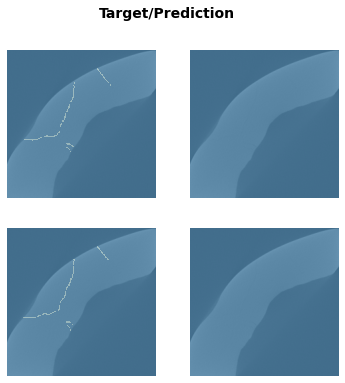

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()

IndexError: ignored

# PyTorch

In [ ]:
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


In [ ]:
class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 preprocessing = None,
                 augmentations = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "rgb") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            preprocessing (albumentations.Compose): data preprocessing for pretrained net. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode
        self.preprocessing = preprocessing
        self.augmentations = augmentations

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices-1]
                self.mask_list = self.mask_list[indices-1]
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])

            return sample

In [ ]:
#!pip install albumentations

In [ ]:
#!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['crack']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = "Images",
                                 mask_folder: str = "Labels",
                                 fraction: float = 0.2,
                                 batch_size: int = 2):
  data_transforms = transforms.Compose([transforms.Resize(556), transforms.RandomCrop(513), transforms.ToTensor()])
  image_datasets = {
      x: SegmentationDataset(data_dir,
                             image_folder=image_folder,
                             mask_folder=mask_folder,
                             seed=42,
                             fraction = fraction,
                             subset=x,
                             transforms=data_transforms)
      for x in ["Train", "Test"]
  }

  dataloaders = {
      x: DataLoader(image_datasets[x],
                    batch_size=batch_size,
                    shuffle=True)
      for x in ["Train", "Test"]
  }

  return dataloaders

In [ ]:
seg_dataloader = get_dataloader_single_folder(path)

In [ ]:
samples = next(iter(seg_dataloader["Test"]))

In [ ]:
display(samples["image"].shape,
        samples["mask"].shape)

torch.Size([2, 3, 513, 513])

torch.Size([2, 3, 513, 513])

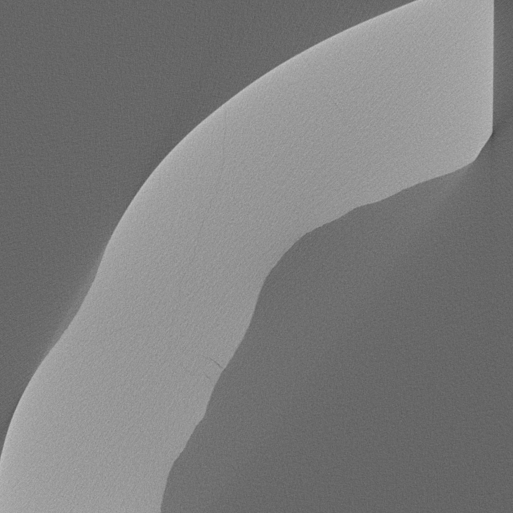

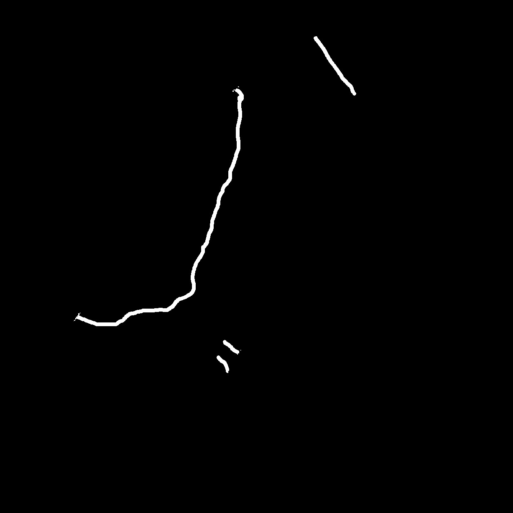

In [ ]:
img = transforms.ToPILImage()(samples['image'][1])
mask = transforms.ToPILImage()(samples['mask'][1])

display(img, mask)

In [ ]:
train_loader = seg_dataloader["Train"]
valid_loader = seg_dataloader["Test"]

In [ ]:
train_loader

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=3e-4)])

In [ ]:
pip install -q torchnet

     |████████████████████████████████| 676 kB 38.0 MB/s 
     |████████████████████████████████| 68 kB 8.0 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=f24188c2fa9fb3c0efbf4c5f7b14c52b541bd27e6f324cda0b62d07a621bf6c0
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655249 sha256=3c0c0dc6392510dc693b6d38dc70907a34afbeb78615651294e3ccbe7767dfbf
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=86dde2f23d2dc0a05723aef06e2fe03bb6cb2a0ac54401395b29dc3bfd9e5bb4
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


In [ ]:
import sys
import torch
from tqdm import tqdm as tqdm
from torchnet.meter import AverageValueMeter



class Epoch:

    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        for sample in tqdm(iter(dataloader)):
          inputs = sample["image"].to(device)
          masks = sample["mask"].to(device)
          optimizer.zero_grad()
          loss, y_pred = self.batch_update(inputs, masks)

        # update loss logs
          loss_value = loss.cpu().detach().numpy()
          loss_meter.add(loss_value)
          loss_logs = {self.loss.__name__: loss_meter.mean}
          logs.update(loss_logs)

        # update metrics logs
          for metric_fn in self.metrics:
              metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
              metrics_meters[metric_fn.__name__].add(metric_value)
          metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
          logs.update(metrics_logs)

          if self.verbose:
              s = self._format_logs(logs)
              iterator.set_postfix_str(s)

        return logs

class TrainEpoch(Epoch):

    def __init__(self, model, loss, metrics, optimizer, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='train',
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

In [ ]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
import copy 
import csv
import time
from tqdm import tqdm
import torch

In [ ]:
import segmentation_models_pytorch as smp


model = smp.DeepLabV3Plus(encoder_name='resnet34',
                            in_channels=3,
                            classes=1,
                            activation="sigmoid")

#preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet34", "imagenet")

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

In [ ]:
import torch

In [ ]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs):
  since = time.time()
  best_model_weights = copy.deepcopy(model.state_dict())
  best_loss = 1e10
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
  [f'Train_{m}' for m in metrics.keys()] + \
  [f'Test_{m}' for m in metrics.keys()]

  with open(os.path.join(bpath, 'log.csv'), 'w', newline = '') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

  for epoch in range(1, num_epochs+1):
    print(f"Epoch: {epoch}/{num_epochs}")
    print("-"*10)

    batchsummary = {a : [0] for a in fieldnames}

    for phase in ["Train", "Test"]:
      if phase == "Train":
        model.train()
      else:
        model.eval()

      for sample in tqdm(iter(dataloaders[phase])):
        inputs = sample["image"].to(device)
        masks = sample["mask"].to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=="Train"):
          outputs = model(inputs)
          loss = criterion(outputs['out'], masks)
          y_pred = outputs['out'].data.cpu().numpy().ravel()
          y_true = masks.data.cpu().numpy().ravel()
          for name, metric in metrics.items():
            if name == "f1_score":
              batchsummary[f'{phase}_{name}'].append(metric(y_true>0, y_pred))
            else:
              batch_summary[f'{phase}_{name}'].append(metric(y_true.astype('uint8'), y_pred))

          if phase == "Train":
            loss.backward()
            optimizer.step()

      batchsummary['epoch'] = epoch
      epoch_loss = loss
      batchsummary[f'{phase}_loss'] = epoch_loss.item()
      print(f'{phase} Loss: {loss}')

      for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
      
      print(batchsummary)

      with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
        writer.writerow(batchsummary)

        if phase == "Test" and loss < best_loss:

          best_loss = loss
          best_model_weights = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed%60))
  print("Lowest Loss : {:.4f}.format(best_loss)")

  model.load_state_dict(best_model_weights)
  return model
  

In [ ]:
ALPHA = 0.3
BETA = 0.7
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [ ]:
exp_directory = path/'exp'

#criterion = FocalTverskyLoss()
criterion = BCEWithLogitsLossFlat()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

metrics = {"f1_score": f1_score, 'auroc': roc_auc_score}

In [ ]:
_ = train_model(model, criterion, seg_dataloader, optimizer, metrics, exp_directory, 30)

torch.save(model, exp_directory/'weights.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/30
----------


  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: ignored